In [ ]:
import numpy as np
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel; print('scikit-allel', allel.__version__)
import zarr

scikit-allel 1.3.5


In [24]:
zarr_path = '/Users/dennistpw/Projects/microctonus/microctonus_genom/snpdata/microctonus_fullcohort.zarr/'
callset = zarr.open_group(zarr_path, mode='r')
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['CHROM','POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'QUAL', 'MQRankSum', 'ReadPosRankSum', 'FS', 'SOR' ,'AF'])

In [28]:
df_samples = pandas.read_csv('/Users/dennistpw/Projects/microctonus/microctonus_genom/sampledata/myhponly_metadata.csv', delimiter=',')
samples = callset['samples']
samples_list = list(samples)
samples_callset_index = [samples_list.index(s) for s in df_samples['sample_id']]
df_samples['callset_index'] = samples_callset_index
#df_samples = df_samples.sort_values('callset_index')
df_samples = df_samples.sort_values('callset_index')
np.all(samples[:] == df_samples['sample_id'].values)


/var/folders/4x/vrllg_b96ll6cgd30x9blq8m0000gn/T/ipykernel_67957/2994579595.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.all(samples[:] == df_samples['sample_id'].values)


False

In [29]:
df_samples.shape

(182, 16)

In [ ]:
def plot_variant_hist(f, bins=30):
    x = variants[f][:]
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)

/Users/dennistpw/mambaforge/envs/microctonus-genome/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6709: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/dennistpw/mambaforge/envs/microctonus-genome/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6710: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


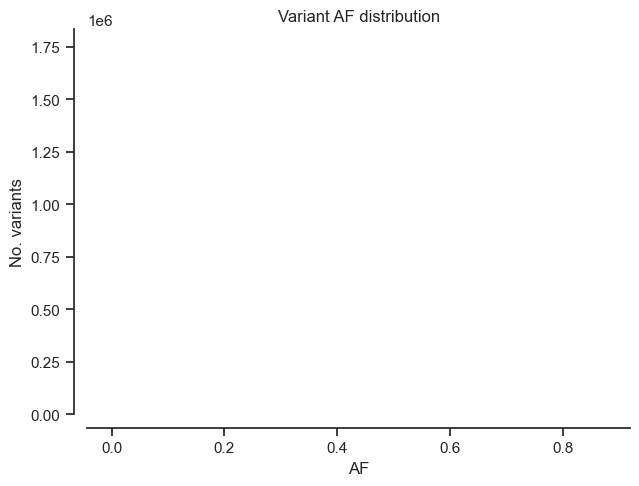

In [ ]:
plot_variant_hist('AF', bins=100)

In [ ]:
plot_variant_hist('DP', bins=100)

In [ ]:
plot_variant_hist('FS')

In [ ]:
plot_variant_hist('MQ')

In [ ]:
plot_variant_hist('QD')

In [ ]:
filter_expression = '(QD > 10) & (AFR'

In [ ]:
variant_selection = variants.eval(filter_expression)[:]
np.count_nonzero(variant_selection)
np.count_nonzero(~variant_selection)
variants_pass = variants.compress(variant_selection)
variants_pass.shape

In [ ]:
def plot_variantpass_hist(f, bins=30):
    x = variants_pass[f][:]
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)
plot_variantpass_hist('DP', bins=100)

In [ ]:
#extract genotypes from filtered data
genotypes = allel.GenotypeChunkedArray(callset['calldata/GT'])
genotypes_subset = genotypes.subset(variant_selection)
n_variants = len(variants_pass)
pc_missing = genotypes_subset.count_missing(axis=0)[:] * 100 / n_variants
pc_het = genotypes_subset.count_het(axis=0)[:] * 100 / n_variants

In [ ]:
def plot_genotype_frequency(pc, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    left = np.arange(len(pc))
    palette = sns.color_palette()
    pop2color = {'M_hyperodae': palette[0], 'M_aethiopoides': palette[1]}
    colors = [pop2color[p] for p in df_samples.Species]
    ax.bar(left, pc, color=colors)
    ax.set_xlim(0, len(pc))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)
    handles = [mpl.patches.Patch(color=palette[0]),
               mpl.patches.Patch(color=palette[1])]
    ax.legend(handles=handles, labels=['M_hyperodae', 'M_aethiopoides'], title='Species',
              bbox_to_anchor=(1, 1), loc='upper left')

In [ ]:
plot_genotype_frequency(pc_missing, 'Missing')

In [ ]:
plot_genotype_frequency(pc_het, 'Heterozygous')

In [ ]:
g = allel.GenotypeChunkedArray(callset['calldata']['GT'])
ac = g.count_alleles()[:]
np.count_nonzero(ac.max_allele() > 1)
#count singletons
np.count_nonzero((ac.max_allele() == 1) & ac.is_singleton(1))
#apply filter
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = g.compress(flt, axis=0)

In [ ]:
#Finally, transform the genotype data into a 2-dimensional matrix where each cell has the number of non-reference alleles per call. This is what we’ll use as the input to PCA.
gn = gf.to_n_alt()

In [ ]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn
gnp = ld_prune(gn, size=500, step=200, threshold=.1, n_iter=1)
#normally just one iteration but can do multiple if you want to see how many get taken

In [ ]:
#flatten from array to GT matrix for PCA
gnu = gn[:]
gnp = gnp[:]

In [ ]:
coords_unpruned, model_unpruned = allel.pca(gnu[:], n_components=10, scaler='patterson')
coords_pruned, model_pruned = allel.pca(gnp[:], n_components=10, scaler='patterson')

In [ ]:
population = df_samples.Location.unique()

In [ ]:
site_colours = {
"Ruakura": "#5A5156",
"Lincoln" : "#E4E1E3",
"Ascasubi" : "#F6222E",
"Bariloche" : "#FE00FA",
"Featherston" : "#16FF32",
"Fortrose" : "#3283FE",
"Hawkes_Bay" : "#FEAF16",
"La_Serena" : "#B00068",
"Mararoa" : "#1CFFCE",
"Mendoza" : "#90AD1C",
"Mossburn" : "#2ED9FF",
"Porto_Alegre" : "#DEA0FD",
"Rio_Negro" : "#AA0DFE",
"Ruakaka" : "#F8A19F",
"South_Chile" : "#325A9B" ,
"Uruguay" : "#C4451C",
"West_Coast_Site_1" : "#1C8356"
}


species_colours = {
    'M_hyperodae': '#00FFFF',
    'M_aethiopoides': '#90EE90',
}

In [ ]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    #populations = df_samples[sample_population].unique()
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[pop], 
                label=pop, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title,  sample_metadata, sample_population=None):
    if sample_population is None:
        sample_population = sample_metadata['Species'].values
    else:
        sample_population = sample_metadata[sample_population].values
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()

In [ ]:
populations = df_samples.Species.unique()
pop_colours=species_colours
fig_pca(coords_unpruned, model_unpruned, 'Figure 4. Conventional PCA, Species, Unpruned GTs', df_samples, sample_population = 'Species')

In [ ]:
populations = df_samples.Location.unique()
pop_colours=site_colours
fig_pca(coords_unpruned, model_unpruned, 'Figure 5. Conventional PCA, Site, Unpruned GTs', df_samples, sample_population = 'Location')

In [ ]:
populations = df_samples.Location.unique()
pop_colours=site_colours
fig_pca(coords_pruned, model_pruned, 'Figure 5. Conventional PCA, Site, Unpruned GTs', df_samples, sample_population = 'Location')

In [ ]:
populations = df_samples.Species.unique()
pop_colours=species_colours
fig_pca(coords_pruned, model_pruned, 'Figure 5. Conventional PCA, Site, Unpruned GTs', df_samples, sample_population = 'Species')

In [ ]:
df_samples.meandepth_Mh_scaffold_1 > 10
mhyp_samples = df_samples[(df_samples.Species == 'M_hyperodae') & (df_samples.meandepth_Mh_scaffold_1 > 10)]
mhyp_sample_indices = mhyp_samples.callset_index.values
gt_hyp = gf.take(mhyp_sample_indices, axis=1)
unlinked_loci = allel.locate_unlinked(gn)
unlinked_gts = gf.subset(unlinked_loci)
mhyp_gt  = unlinked_gts.take(mhyp_sample_indices, axis=1)
unlinked_gts = gf.subset(unlinked_loci)
mhyp_gt  = unlinked_gts.take(mhyp_sample_indices, axis=1)
#plot_ld(mhyp_gt.to_n_alt()[:1000], 'Figure 2. Pairwise LD after LD pruning.')

In [ ]:
ac = mhyp_gt.count_alleles()[:]
np.count_nonzero(ac.max_allele() > 1)
#count singletons
np.count_nonzero((ac.max_allele() == 1) & ac.is_singleton(1))
#apply filter
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = mhyp_gt.compress(flt, axis=0)
mhalt = gf.to_n_alt()
#do pca
coords_mhonly_pruned, model_mhonly_pruned = allel.pca(mhalt[:], n_components=10, scaler='patterson')
#subset metadata

In [ ]:
populations = mhyp_samples.Species.unique()
pop_colours=species_colours
fig_pca(coords_mhonly_pruned, model_mhonly_pruned, 'Figure 5. Conventional PCA, Site, Unpruned GTs',  mhyp_samples, sample_population = 'Species')

In [ ]:
populations = mhyp_samples.Location.unique()
pop_colours=site_colours
fig_pca(coords_mhonly_pruned, model_mhonly_pruned, 'Figure 5. Conventional PCA, Site, Unpruned GTs',  mhyp_samples, sample_population = 'Location')